C:\Users\gonza\AppData\Local\Temp\ipykernel_27132\3507088284.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
C:\Users\gonza\AppData\Local\Temp\ipykernel_27132\3507088284.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For


Resultados de los modelos:
     Modelo Capas ocultas Activación Optimizador      LR  Épocas  Batch size  \
0  Modelo_1          [16]       relu        adam  0.0010      50          32   
1  Modelo_2       [32,16]       tanh         sgd  0.0100     100          16   
2  Modelo_3    [64,32,16]       relu        adam  0.0005      50          64   

  Dropout  Tiempo (s)  Accuracy  Precision  Recall  F1-Score  \
0      No        0.40    0.7494     0.7500  0.7461    0.7481   
1      No        1.95    0.7674     0.7512  0.7979    0.7739   
2      No        0.48    0.7726     0.7586  0.7979    0.7778   

  Confusión [TN, FP, FN, TP]  
0         [146, 48, 49, 144]  
1         [143, 51, 39, 154]  
2         [145, 49, 39, 154]  


c:\Users\gonza\OneDrive\Escritorio\Codigo\Facultad\mierda_jaquelin\integrador_si\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


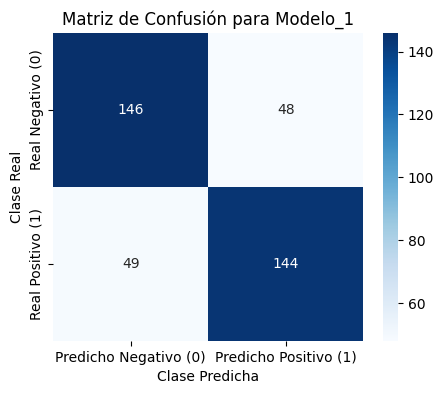

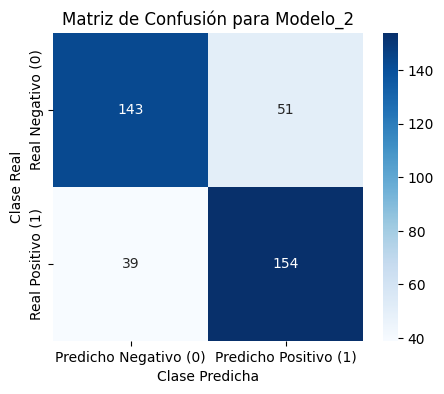

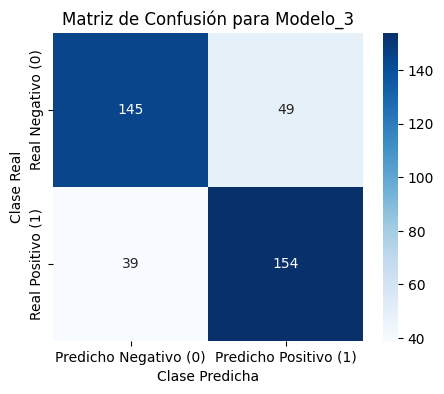

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Carga del dataset
df = pd.read_csv(r'train_and_test2.csv')

# Normalizar nombres de columnas
df.columns = df.columns.str.lower().str.strip()
# Renombrar columna de supervivencia si tiene nombre atípico
if '2urvived' in df.columns:
    df = df.rename(columns={'2urvived': 'survived'})

# Eliminar columnas irrelevantes
drop_cols = [c for c in ['passengerid','name','ticket','cabin'] if c in df.columns]
df = df.drop(drop_cols, axis=1)
# Eliminar columnas residuales de dummy (ej. 'zero', 'zero.1', etc.)
zero_cols = [c for c in df.columns if c.startswith('zero')]
df = df.drop(zero_cols, axis=1)

# Imputar datos faltantes
df['age'].fillna(df['age'].median(), inplace=True)
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

# Separar características y objetivo
X = df.drop('survived', axis=1)
y = df['survived']

# Codificar 'sex' si es texto
if X['sex'].dtype == object:
    X['sex'] = X['sex'].map({'male': 0, 'female': 1})

# One-hot encoding para 'embarked'
X = pd.get_dummies(X, columns=['embarked'], drop_first=True)

# Normalizar variables numéricas
numeric_cols = ['age', 'fare', 'sibsp', 'parch', 'sex']
# Ensure all numeric_cols are present in X before scaling
numeric_cols = [col for col in numeric_cols if col in X.columns]
if numeric_cols: # Proceed only if there are numeric columns to scale
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Balanceo por oversampling de la clase minoritaria
df_bal = pd.concat([X, y], axis=1)
df_majority = df_bal[df_bal.survived == 0]
df_minority = df_bal[df_bal.survived == 1]

# Check if minority class is empty before resampling
if not df_minority.empty and not df_majority.empty:
    df_min_up = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
    df_balanced = pd.concat([df_majority, df_min_up])
else: # Handle cases where one class might be empty or not enough data
    df_balanced = df_bal 

X_bal = df_balanced.drop('survived', axis=1)
y_bal = df_balanced['survived']

# División en entrenamiento y test
# Ensure there's enough data to split
if len(X_bal) > 1 and len(y_bal) > 1:
    # Check for sufficient samples in each class for stratification
    if y_bal.nunique() > 1 and y_bal.value_counts().min() > 1:
        X_train, X_test, y_train, y_test = train_test_split(
            X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
        )
    else: # Fallback if stratification is not possible
        X_train, X_test, y_train, y_test = train_test_split(
            X_bal, y_bal, test_size=0.2, random_state=42
        )
else: # Handle case with insufficient data for splitting
    # Fallback: use the whole dataset for both training and testing (not ideal, but avoids error)
    # Or, raise an error/warning
    print("Warning: Insufficient data for a proper train/test split. Using all available data for training and testing.")
    X_train, X_test, y_train, y_test = X_bal, X_bal, y_bal, y_bal


# Definición de tres modelos MLPClassifier
models = [
    {
        'name': 'Modelo_1',
        'clf': MLPClassifier(hidden_layer_sizes=(16,), activation='relu', solver='adam',
                             learning_rate_init=0.001, max_iter=50, batch_size=32, random_state=42),
        'params': {
            'Capas ocultas': '[16]',
            'Activación': 'relu',
            'Optimizador': 'adam',
            'LR': 0.001,
            'Épocas': 50,
            'Batch size': 32,
            'Dropout': 'No'
        }
    },
    {
        'name': 'Modelo_2',
        'clf': MLPClassifier(hidden_layer_sizes=(32,16), activation='tanh', solver='sgd',
                             learning_rate_init=0.01, max_iter=100, batch_size=16, random_state=42),
        'params': {
            'Capas ocultas': '[32,16]',
            'Activación': 'tanh',
            'Optimizador': 'sgd',
            'LR': 0.01,
            'Épocas': 100,
            'Batch size': 16,
            'Dropout': 'No'
        }
    },
    {
        'name': 'Modelo_3',
        'clf': MLPClassifier(hidden_layer_sizes=(64,32,16), activation='relu', solver='adam',
                             learning_rate_init=0.0005, max_iter=50, batch_size=64, random_state=42),
        'params': {
            'Capas ocultas': '[64,32,16]',
            'Activación': 'relu',
            'Optimizador': 'adam',
            'LR': 0.0005,
            'Épocas': 50,
            'Batch size': 64,
            'Dropout': 'No'
        }
    }
]

# Entrenamiento y evaluación
results = []
# Ensure X_train and y_train are not empty before fitting models
if not X_train.empty and not y_train.empty:
    for m in models:
        start = time.time()
        m['clf'].fit(X_train, y_train)
        elapsed = time.time() - start
        
        # Ensure X_test is not empty before predicting
        if not X_test.empty:
            y_pred = m['clf'].predict(X_test)
            # Ensure y_test is not empty and has more than one class for metrics
            if not y_test.empty and y_test.nunique() > 1:
                acc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred, zero_division=0)
                rec = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                cm = confusion_matrix(y_test, y_pred)
            else: # Fallback if metrics cannot be calculated
                acc, prec, rec, f1 = np.nan, np.nan, np.nan, np.nan
                cm = np.array([[np.nan, np.nan], [np.nan, np.nan]]) # Placeholder CM
        else: # Fallback if X_test is empty
            y_pred = np.array([])
            acc, prec, rec, f1 = np.nan, np.nan, np.nan, np.nan
            cm = np.array([[np.nan, np.nan], [np.nan, np.nan]])

        row = {
            'Modelo': m['name'],
            **m['params'],
            'Tiempo (s)': round(elapsed, 2),
            'Accuracy': round(acc, 4) if not np.isnan(acc) else np.nan,
            'Precision': round(prec, 4) if not np.isnan(prec) else np.nan,
            'Recall': round(rec, 4) if not np.isnan(rec) else np.nan,
            'F1-Score': round(f1, 4) if not np.isnan(f1) else np.nan,
            'Confusión [TN, FP, FN, TP]': cm.flatten().tolist()
            }
        results.append(row)
else:
    print("Error: Training data is empty. Cannot train models.")

# Mostrar resultados
df_results = pd.DataFrame(results)

print("\nResultados de los modelos:")
print(df_results)


# Graficar matrices de confusión
if not df_results.empty:
    for index, row_data in df_results.iterrows():
        model_name = row_data['Modelo']
        cm_flat = row_data['Confusión [TN, FP, FN, TP]']
        
        # Check if confusion matrix data is valid (not NaN)
        if not any(np.isnan(c) for c in cm_flat):
            # CM is stored as [TN, FP, FN, TP]
            # Reshape it to [[TN, FP], [FN, TP]]
            conf_matrix = np.array([[cm_flat[0], cm_flat[1]], [cm_flat[2], cm_flat[3]]]).astype(int)
            
            plt.figure(figsize=(5, 4))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Predicho Negativo (0)', 'Predicho Positivo (1)'], 
                        yticklabels=['Real Negativo (0)', 'Real Positivo (1)'])
            plt.title(f'Matriz de Confusión para {model_name}')
            plt.ylabel('Clase Real')
            plt.xlabel('Clase Predicha')
            plt.show()
        else:
            print(f"No se puede graficar la matriz de confusión para {model_name} debido a datos faltantes.")
else:
    print("No hay resultados para mostrar o graficar.")



In [2]:
import pandas as pd

archivo = 'train_and_test2.csv'

df = pd.read_csv(archivo)

df.columns

Index(['Passengerid', 'Age', 'Fare', 'Sex', 'sibsp', 'zero', 'zero.1',
       'zero.2', 'zero.3', 'zero.4', 'zero.5', 'zero.6', 'Parch', 'zero.7',
       'zero.8', 'zero.9', 'zero.10', 'zero.11', 'zero.12', 'zero.13',
       'zero.14', 'Pclass', 'zero.15', 'zero.16', 'Embarked', 'zero.17',
       'zero.18', '2urvived'],
      dtype='object')